In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

# Import training set augmented with LIDAR
LIDAR source 
https://forestobservatory.com (3m resolution)

In [3]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation_w_lidar','trainset_non_iceplant_vegetation_w_lidar.csv')
noniceplant_features_df = pd.read_csv(fp)
noniceplant_features_df.head(1)

,Unnamed: 0,r,g,b,nifr,lidar,iceplant,geometry
0,0,163,144,116,183,0,0,POINT (237140.55244983424 3814526.169987386)


In [4]:
# fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_trees','trainset_trees.csv')
# trees_df = pd.read_csv(fp)
# trees_df.head(3)

In [5]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG_w_lidar','trainset_BIG_w_lidar.csv')
features_df = pd.read_csv(fp)
features_df.head(1)

,Unnamed: 0,r,g,b,nifr,lidar,iceplant,geometry
0,0,87,80,87,140,3,1,POINT (238502.90962098932 3810767.0101709934)


In [6]:
# add non-iceplant vegetation points sample to BIG training set 
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.01)])
features_df.drop(['geometry','Unnamed: 0'],axis=1,inplace=True)
ipf.iceplant_counts(features_df)

,iceplant,count
0,0,5113
1,1,1609


# Train model

In [7]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
ipf.test_train_proportions(train_labels, test_labels)

Training Features Shape: (4705, 5)
Training Labels Shape: (4705,)
Testing Features Shape: (2017, 5)
Testing Labels Shape: (2017,)

TRAIN SET: Iceplant / no iceplant counts
[[   0 3590]
 [   1 1115]] 

TEST SET: Iceplant / no iceplant counts
[[   0 1523]
 [   1  494]]



In [8]:
# Train random forest classifier
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(n_estimators=150, random_state=42)

Mean Absolute Error: 0.01

true negatives: 1512     false positives: 11
false negatives: 13     true positives: 481

true negative %: 99.28
true positive rate %: 97.37

accuracy %: 98.81



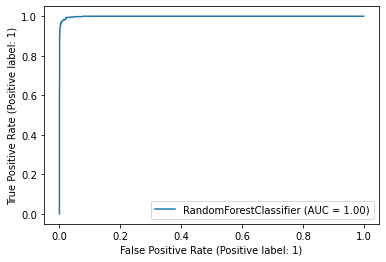

In [9]:
predictions = rfc.predict(test_features)

ipf.print_rfc_evaluation(rfc, test_features, test_labels, predictions)

# Applying model with lidar to NAIP subsets

In [10]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

In [11]:
#obtain href to NAIP scene

URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

search = catalog.search(
        collections=["naip"],
        ids = cp.itemid        
    )

item = list(search.get_items())[0]
href = pc.sign(item.assets["image"].href)

In [12]:
# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))
#naip_scene = xr.open_dataset(href, engine='rasterio')
naip_scene

<xarray.DataArray (band: 4, y: 12340, x: 10420)>
[514331200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.355e+05 2.355e+05 ... 2.417e+05 2.417e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [13]:
# clip NAIP scene to aoi
reduce = aois.iloc[[0]] # retrieve row as gpd GeoDataFrame
#reduce

ds = rasterio.open(href)  # need to poen ds (reader) to obtain crs?

#reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

In [14]:
# mask naip scene with Campus Point bounding box
naip_clip = naip_scene.rio.clip_box(*reduce.total_bounds)
naip_clip

<xarray.DataArray (band: 4, y: 1925, x: 1969)>
[15161300 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Open, mask and resample LIDAR raster

In [15]:
fp = os.path.join(os.getcwd(),'training_set','3mlidar_over_campuspoint_naip_scene.tif')
lidar = rioxr.open_rasterio(fp)

# resample using the naip_subset
lidar_match = lidar.rio.reproject_match(naip_clip)
lidar_match = lidar_match.squeeze()
lidar_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       [    3,     3,     3, ...,     1,     1,     1],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999

### Add LIDAR as feature to NAIP subset

In [16]:
image = naip_clip.to_numpy()    # extract np array
veg = ipf.select_ndvi_df(image) # extract pixels with vegetation as df

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


In [17]:
lidar_np = lidar_match.to_numpy() # extract lidar data as np array (same extent as image, but only one band)

# sample lidar from vegetation indices
lidar_veg = []
for n in veg.index:
    i = int((n)/lidar_np.shape[1])
    j = (n) % lidar_np.shape[1]
    lidar_veg.append(lidar_np[i][j])

veg['lidar']=lidar_veg
veg

,r,g,b,nir,lidar
31,95,92,98,156,4
34,101,102,103,157,4
35,98,100,99,148,4
36,93,95,98,142,4
37,82,81,89,153,4
...,...,...,...,...,...
3788458,34,49,63,61,-9999
3788459,33,45,61,51,-9999
3788462,38,47,61,67,-9999
3788463,37,49,63,68,-9999


### make predictions and reshape into image

In [18]:
features = np.array(veg)
predictions_class = rfc.predict(features)
c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = veg.index)

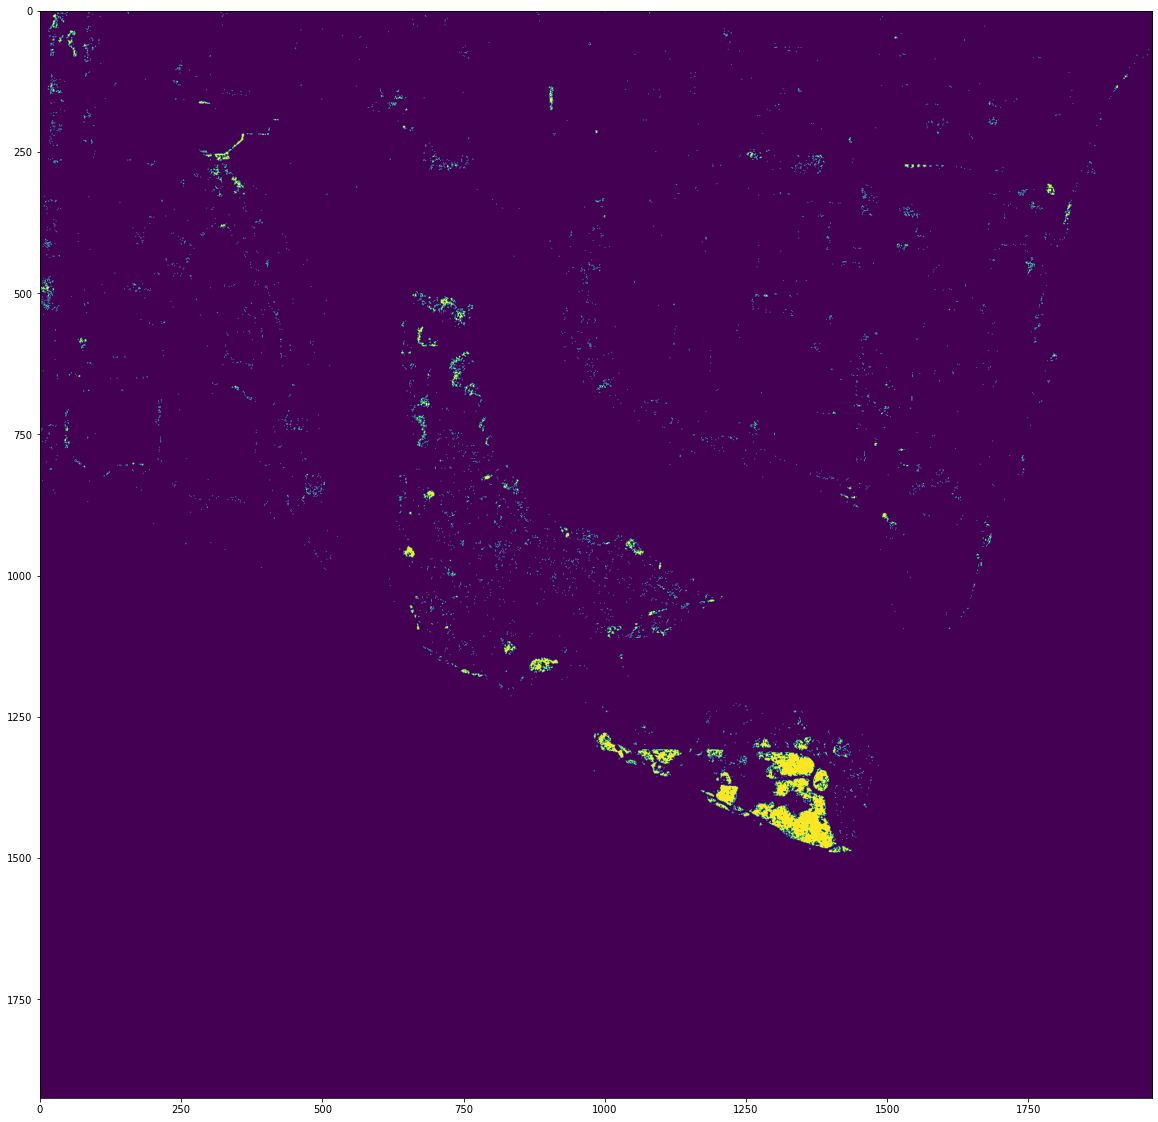

In [19]:
predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(predictions)
plt.show()